###### Homework 3  Due Nov 12th Mengying Bi

## What to turn in:
  - Turn in code as well as results (with plots) as listed in each question
  - Submit everything as a single pdf or Markdown file
  
## Data

The data takes the form of a table with five attributes:

| ID | X | Y | Z | W |
|----|---|---|---|---|
| 1237661088029606015 | 0.575469| 1.37509| 1.941| -0.0360003 |
| 1237661088024822536 | 1.00735| 3.06909| 3.701| -0.059 |     
| 1237661088024822606| 1.4684| 2.5072| 3.184| -0.105 |     
| 1237661088024887302 | 0.761256| 1.44754| 1.356| -0.0959997 | 

The first attribute, `ID`, is a unique identifier for each source. Each of the other four attributes, `X`, `Y`, `Z`, and `W` is a measurement for that source. Thus each column is a type of measurement and each row is a source.

## Environment

Spark MLLib implements GMM and, in this assignment, we will use it to
cluster 1.9M astronomical sources:
1. Deploy EMR with Spark: To deploy Spark on Elastic MapReduce use the instructions from the Spark section(s).
  - *Make sure that your security group has the inbound ports listed in the section notes open*
  - *Make sure you select a key pair that you have access to!*
2. Data load and transform: Data is provided in the form of CSV files in S3. 
  - Read the data from S3. 
  - Parse it and otherwise prepare it as needed for the analysis.
  - Bucket: `csed516`
  - Key: `smalldatasetspark/wise-colors-15-20-subsetsmall8.csv`
  
3. Run GMM: From MLlib on Spark, the GMM implementation is available in Scala, Java, Python and R.
    Choose the language that you prefer and run GMM on the sources that you prepared above. Remember the points are in four dimensions.


In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import GaussianMixture
import time

In [2]:
def formatData(df):
    df = df.withColumnRenamed('_c0', 'ID')
    df = df.withColumnRenamed('_c1', 'X')
    df = df.withColumnRenamed('_c2', 'Y')
    df = df.withColumnRenamed('_c3', 'Z')
    df = df.withColumnRenamed('_c4', 'W')
    # assemble the features
    vecAssembler = VectorAssembler(inputCols=['X', 'Y', 'Z', 'W'], outputCol="features")
    new_df = vecAssembler.transform(df)
    return new_df

In [3]:
spark = SparkSession.builder.appName('Python Spark SQL basic example').config('spark.some.config.option', 
                                                                              'some-value').getOrCreate()
df_small = spark.read.csv('s3n://csed516/smalldatasetspark/wise-colors-15-20-subsetsmall8.csv',
                    header='false', inferSchema='true')

## Questions

### 1. Find and describe components (20 Points)
  - Use the MLlib implementation of GMM with k=7 components to build a model of the data.
  - List the weight, mean(mu), and covariance matrix of each component.
  - Run this experiment on a 2-node (i.e., 2-instance) cluster. On each instance, run a single worker.
  - If you choose to change the number of partitions, report the number of partitions you chose.

In [4]:
new_df_small = formatData(df_small)
new_df_small.show()

+-------------------+--------+-------+-----+----------+--------------------+
|                 ID|       X|      Y|    Z|         W|            features|
+-------------------+--------+-------+-----+----------+--------------------+
|1237661088029606015|0.575469|1.37509|1.941|-0.0360003|[0.575469,1.37509...|
|1237661088024822536| 1.00735|3.06909|3.701|    -0.059|[1.00735,3.06909,...|
|1237661088024822606|  1.4684|2.50721|3.184|    -0.105|[1.4684,2.50721,3...|
|1237661088024887302|0.761256|1.44754|1.356|-0.0959997|[0.761256,1.44754...|
|1237661088024887415| 1.07245|2.14364| 2.34|    -0.116|[1.07245,2.14364,...|
|1237661088024887822| 1.04168|1.47494|2.867|     0.212|[1.04168,1.47494,...|
|1237661088030654878| 2.01709|2.27154|3.895|     0.345|[2.01709,2.27154,...|
|1237661088029409748| 2.75679|3.05706|2.549|  0.151999|[2.75679,3.05706,...|
|1237661088029409754| 2.75929|3.17937|2.958| 0.0609999|[2.75929,3.17937,...|
|1237661088029540425| 1.07304|1.87115|1.601|-0.0149994|[1.07304,1.87115,...|

In [5]:
def trainModel(df):
    start_time = time.time()
    # fit the GMM model
    gmm = GaussianMixture().setK(7).setSeed(1).setMaxIter(200)
    model = gmm.fit(df)
    print("--- %s seconds ---" % (time.time() - start_time))
    return model

In [6]:
# print("Gaussians shown as a DataFrame: ")
# model_small_2.gaussiansDF.show(truncate = False)
def getParameter(model):
    print "mean for each component:"
    print model.gaussiansDF.select("mean").collect()
    print "weight for each component:"
    print model.weights
    print "cov for each component:"
    print model.gaussiansDF.select("cov").collect()

In [7]:
model_small_2 = trainModel(new_df_small.select('features'))

--- 597.240535021 seconds ---


In [8]:
getParameter(model_small_2)

mean for each component:
[Row(mean=DenseVector([2.2021, 2.6915, 2.0887, 0.0242])), Row(mean=DenseVector([2.1491, 5.5816, 0.97, 0.0303])), Row(mean=DenseVector([2.2238, 3.3768, 2.3494, 0.0132])), Row(mean=DenseVector([0.6481, 2.4658, 3.6465, 0.4847])), Row(mean=DenseVector([0.7914, 1.6056, 2.3611, -0.0764])), Row(mean=DenseVector([1.4061, 2.1771, 3.4833, 0.2335])), Row(mean=DenseVector([1.766, 3.3841, 3.3769, 0.1016]))]
weight for each component:
[0.22507825404175122, 0.01615292049666922, 0.12367600369601525, 0.04192978187280784, 0.20727952266313557, 0.30547615802613237, 0.08040735920348854]
cov for each component:
[Row(cov=DenseMatrix(4, 4, [0.2612, 0.1949, -0.0071, 0.0407, 0.1949, 0.16, -0.0136, 0.0298, -0.0071, -0.0136, 0.8973, -0.0165, 0.0407, 0.0298, -0.0165, 0.0196], False)), Row(cov=DenseMatrix(4, 4, [9.2096, -0.4314, 0.7461, 0.1242, -0.4314, 5.4519, 0.5649, 0.0777, 0.7461, 0.5649, 2.1788, -0.0028, 0.1242, 0.0777, -0.0028, 0.0741], False)), Row(cov=DenseMatrix(4, 4, [1.3389, 1.23

After a few times of running the model, I set the max iteration to be 200. Based on my experienments, I believe 200 is large enough for convergence and save the time to do excessive training. Training time varies from 400 - 600 and I assume the varience in time may be dute to bootstrap time of the spark nodes and AWS busy time.

### 2. Plot the source clusters (10 Points)
  - Each point is represented in four dimensions(X,Y,Z,W).
  - Plot one or more 3D or 2D plots with a subset of the dimensions of your choosing
    to show the sources with each cluster of points denoted by a
	different color.

The training data is in 4 dimensions. So I picked 3 dimensions each time, one covers dimension X, Y, Z and the second one covers Y, Z, W.

In [9]:
# transform the initial dataframe to include cluster assignments
transformed = model_small_2.transform(new_df_small)
transformed.show()    

+-------------------+--------+-------+-----+----------+--------------------+----------+--------------------+
|                 ID|       X|      Y|    Z|         W|            features|prediction|         probability|
+-------------------+--------+-------+-----+----------+--------------------+----------+--------------------+
|1237661088029606015|0.575469|1.37509|1.941|-0.0360003|[0.575469,1.37509...|         4|[0.00123119472958...|
|1237661088024822536| 1.00735|3.06909|3.701|    -0.059|[1.00735,3.06909,...|         3|[2.33596459752438...|
|1237661088024822606|  1.4684|2.50721|3.184|    -0.105|[1.4684,2.50721,3...|         5|[0.01052215446680...|
|1237661088024887302|0.761256|1.44754|1.356|-0.0959997|[0.761256,1.44754...|         4|[0.00722823860668...|
|1237661088024887415| 1.07245|2.14364| 2.34|    -0.116|[1.07245,2.14364,...|         4|[0.02421083042331...|
|1237661088024887822| 1.04168|1.47494|2.867|     0.212|[1.04168,1.47494,...|         5|[2.93015815754872...|
|123766108803065487

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

In [12]:
transformed = model_small_2.transform(new_df_small).select("features", "prediction")
pddf = transformed.toPandas()
fv=pddf['features'].values.tolist()
fv=map(np.asarray,fv)
fv=pd.DataFrame(fv, dtype='float')
fv.columns=['X','Y','Z','W']
pddf['prediction'] = pddf['prediction'].astype(str)

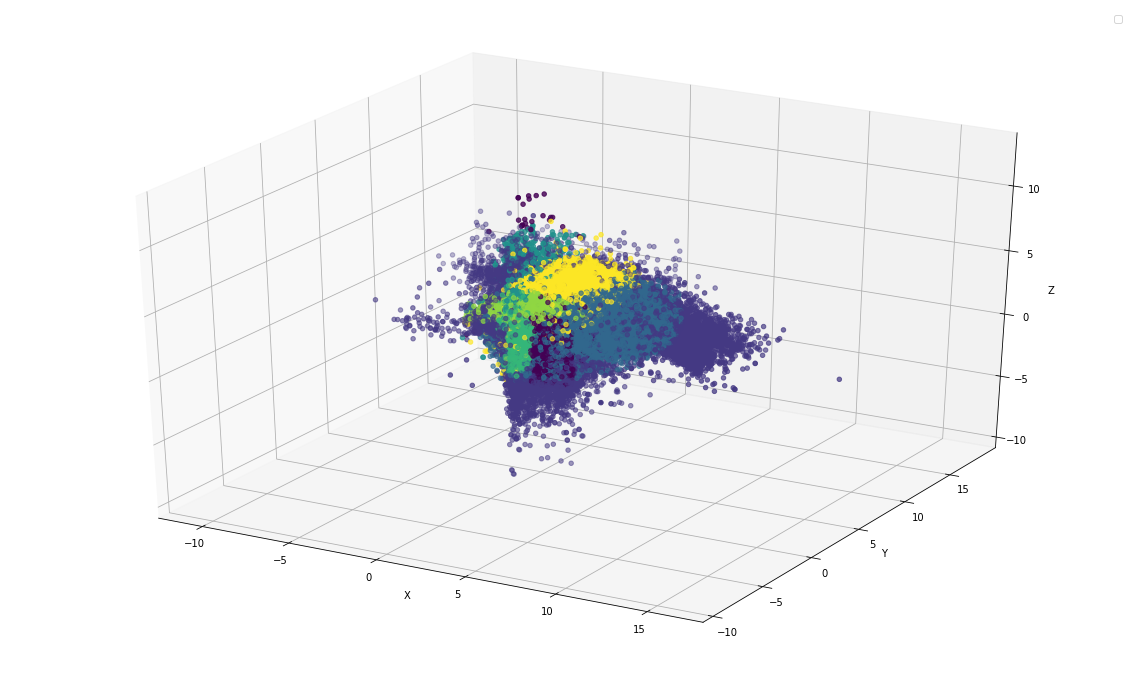

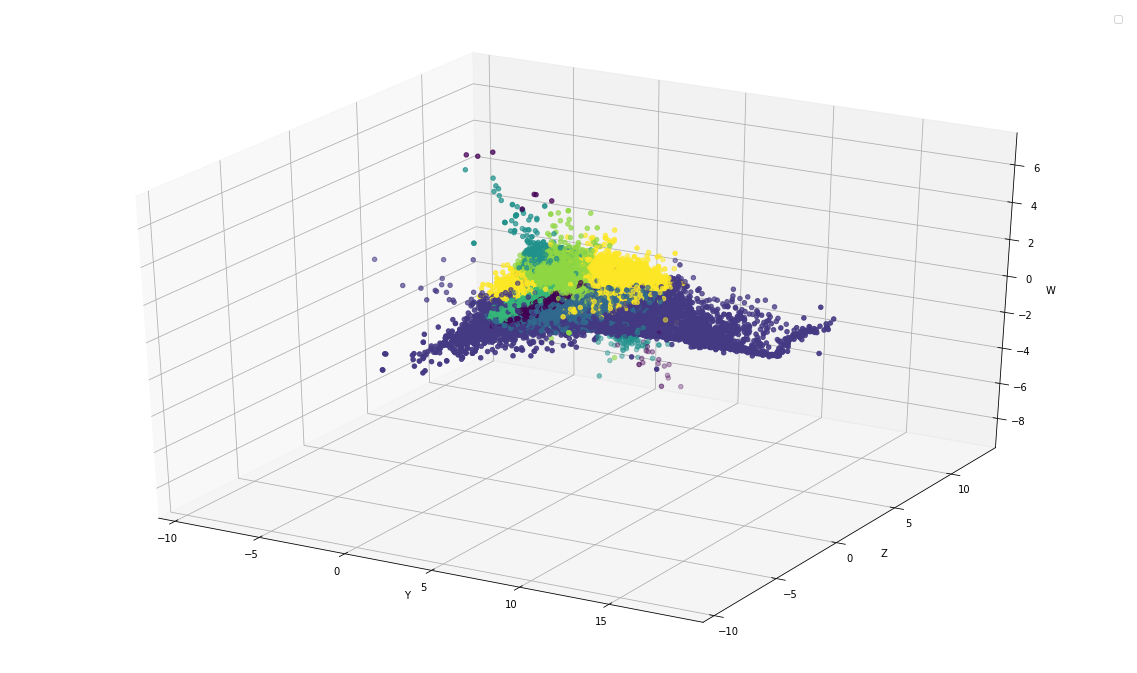

In [13]:
fig1=plt.figure(figsize=(20,12))
ax=fig1.add_subplot(111,projection='3d')
ax.scatter(fv['X'],fv['Y'],fv['Z'],c=pddf['prediction'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

fig2=plt.figure(figsize=(20,12))
ax=fig2.add_subplot(111,projection='3d')
ax.scatter(fv['Y'],fv['Z'],fv['W'],c=pddf['prediction'])
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('W')
plt.show()

### 3. Explore speed-up (20 Points)
  - In this part of the assignment, we will evaluate Spark's speed-up on the GMM algorithm.
  - For this, we keep the data size and task fixed and vary the number of cores/compute nodes available for processing. 
  - Describe how the runtime varies when you change the number of instances in the Spark cluster.
  - Vary the number of instances from 2 to 4 to 8 and plot the runtime for finding 7 components as in question 1. You already ran part 1 with 2 instances. For this part, you only need to run GMM on 4 and 8 instance clusters. You can continue to use one worker per instance. Report the runtimes. 
  - If you choose to change the number of partitions, report the number of partitions.

In [17]:
# run after changing node size to 4
model_small_4 = trainModel(new_df_small.select('features'))

--- 640.132472992 seconds ---


In [19]:
# run after changing node size to 8
model_small_8 = trainModel(new_df_small.select('features'))

--- 974.780186892 seconds ---


Text(0.5,1,'Runtime for Finding 7 Components with Different Number of Instances')

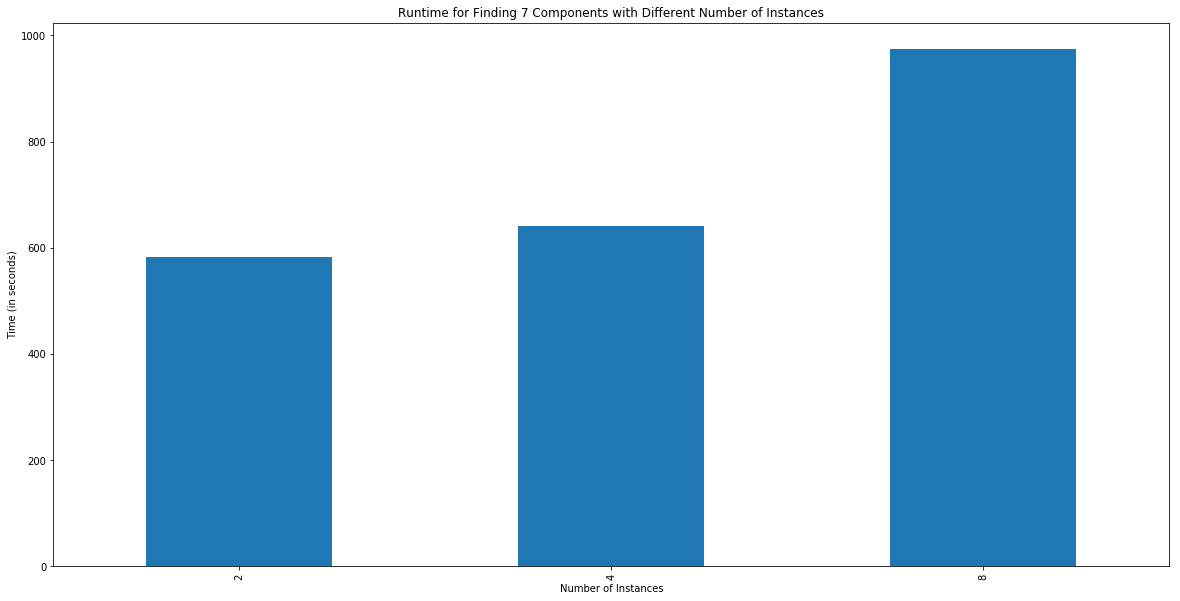

In [20]:
# Plot the runtime based on the results of the lastest iterations
# The variations of runtimes are described in the previous sections
s = pd.Series([597.24,640.13,974.78], index=['2','4','8'])
s.plot.bar(figsize=(20,10))
plt.xlabel('Number of Instances')
plt.ylabel('Time (in seconds)')
plt.title("Runtime for Finding 7 Components with Different Number of Instances")

As I change the number of instances in the Spark cluster, the runtime increases as node size increases. This is the opposite to the assumption I had, that there should be linear speed-up as node size increases.

This might be caused by the following reasons:

- The bootstrap time will be the same regardless of number of workers.
- There might be communication cost when sharing the memory and passing messages between workers and master. Therefore, even with more workers, each one of them might need to wait for the data to be allocated and might not be operating at its full capacity. 
- Since Spark cluster is a distributed system, there might be multiple reasons that affect performance. 
- AWS might be up time and down times, which makes a difference in runtime.
- There might be an increase in overhead of sychronizing data between workers, as the number of worker increases.

### 4. Explore scale-up (20 points)
  - In this part, we increase the data set size and see how the change in the data size impacts the analysis time. For this a larger dataset with 15M sources is located at:
    - Bucket: `csed516`
    - Key: `largerdatasetspark/wise-colors-15-20-subset1.csv`
  - Run GMM on this larger dataset and on the 2 node cluster.
  - Report the execution time as well the number of partitions for this dataset.  
  - Compare the components that you get on this larger dataset vs the one your got on the smaller data set.



In [5]:
df_large = spark.read.csv('s3n://csed516/largerdatasetspark/wise-colors-15-20-subset1.csv',
                    header='false', inferSchema='true')
new_df_large = formatData(df_large)
new_df_large.show()

+-------------------+--------+-------+-----+----------+--------------------+
|                 ID|       X|      Y|    Z|         W|            features|
+-------------------+--------+-------+-----+----------+--------------------+
|1237661088029606015|0.575469|1.37509|1.941|-0.0360003|[0.575469,1.37509...|
|1237661088024822536| 1.00735|3.06909|3.701|    -0.059|[1.00735,3.06909,...|
|1237661088024822606|  1.4684|2.50721|3.184|    -0.105|[1.4684,2.50721,3...|
|1237661088024887302|0.761256|1.44754|1.356|-0.0959997|[0.761256,1.44754...|
|1237661088024887415| 1.07245|2.14364| 2.34|    -0.116|[1.07245,2.14364,...|
|1237661088024887822| 1.04168|1.47494|2.867|     0.212|[1.04168,1.47494,...|
|1237661088030654878| 2.01709|2.27154|3.895|     0.345|[2.01709,2.27154,...|
|1237661088029409748| 2.75679|3.05706|2.549|  0.151999|[2.75679,3.05706,...|
|1237661088029409754| 2.75929|3.17937|2.958| 0.0609999|[2.75929,3.17937,...|
|1237661088029540425| 1.07304|1.87115|1.601|-0.0149994|[1.07304,1.87115,...|

In [22]:
# fit the GMM model
model_large_2 = trainModel(new_df_large.select('features'))

--- 4627.15346217 seconds ---


In [23]:
getParameter(model_large_2)

mean for each component:
[Row(mean=DenseVector([1.791, 3.0269, 2.4161, 0.0154])), Row(mean=DenseVector([1.6082, 5.0351, 1.2539, -0.0684])), Row(mean=DenseVector([1.9704, 2.6103, 3.4813, 0.2074])), Row(mean=DenseVector([0.9024, 1.7024, 2.3027, -0.0769])), Row(mean=DenseVector([0.8762, 1.7972, 3.4918, 0.2336])), Row(mean=DenseVector([1.2233, 3.2294, 3.4983, 0.2933])), Row(mean=DenseVector([2.2359, 2.7158, 2.1621, 0.0097]))]
weight for each component:
[0.16013198312614646, 0.018420337532729758, 0.18736538494037522, 0.20587871222288498, 0.20235739336292627, 0.05309565797312813, 0.17275053084180916]
cov for each component:
[Row(cov=DenseMatrix(4, 4, [0.6523, 0.4963, 0.0103, 0.0138, 0.4963, 0.6104, 0.0079, 0.0061, 0.0103, 0.0079, 1.1955, 0.0159, 0.0138, 0.0061, 0.0159, 0.0225], False)), Row(cov=DenseMatrix(4, 4, [7.1881, -0.775, 0.6444, 0.0861, -0.775, 5.7335, -0.5207, 0.2425, 0.6444, -0.5207, 3.5791, -0.5304, 0.0861, 0.2425, -0.5304, 0.3011], False)), Row(cov=DenseMatrix(4, 4, [0.2473, 0.16

- Runtime for small dataset:581.73
- Runtime for large dataset: 4627.15
- Weight for small dataset
weight for each component:
[0.22507825404175716, 0.016152920496667948, 0.12367600369602037, 0.04192978187280733, 0.2072795226631304, 0.3054761580261412, 0.08040735920347554]

- Weight for large dataset
weight for each component:
[0.16013198312614646, 0.018420337532729758, 0.18736538494037522, 0.20587871222288498, 0.20235739336292627, 0.05309565797312813, 0.17275053084180916]

- mean for small seatset
[Row(mean=DenseVector([2.2021, 2.6915, 2.0887, 0.0242])), Row(mean=DenseVector([2.1491, 5.5816, 0.97, 0.0303])), Row(mean=DenseVector([2.2238, 3.3768, 2.3494, 0.0132])), Row(mean=DenseVector([0.6481, 2.4658, 3.6465, 0.4847])), Row(mean=DenseVector([0.7914, 1.6056, 2.3611, -0.0764])), Row(mean=DenseVector([1.4061, 2.1771, 3.4833, 0.2335])), Row(mean=DenseVector([1.766, 3.3841, 3.3769, 0.1016]))]

- mean for large dataset
mean for each component:
[Row(mean=DenseVector([1.791, 3.0269, 2.4161, 0.0154])), Row(mean=DenseVector([1.6082, 5.0351, 1.2539, -0.0684])), Row(mean=DenseVector([1.9704, 2.6103, 3.4813, 0.2074])), Row(mean=DenseVector([0.9024, 1.7024, 2.3027, -0.0769])), Row(mean=DenseVector([0.8762, 1.7972, 3.4918, 0.2336])), Row(mean=DenseVector([1.2233, 3.2294, 3.4983, 0.2933])), Row(mean=DenseVector([2.2359, 2.7158, 2.1621, 0.0097]))]

- covariance for small dataset
cov for each component:
[Row(cov=DenseMatrix(4, 4, [0.2612, 0.1949, -0.0071, 0.0407, 0.1949, 0.16, -0.0136, 0.0298, -0.0071, -0.0136, 0.8973, -0.0165, 0.0407, 0.0298, -0.0165, 0.0196], False)), Row(cov=DenseMatrix(4, 4, [9.2096, -0.4314, 0.7461, 0.1242, -0.4314, 5.4519, 0.5649, 0.0777, 0.7461, 0.5649, 2.1788, -0.0028, 0.1242, 0.0777, -0.0028, 0.0741], False)), Row(cov=DenseMatrix(4, 4, [1.3389, 1.2317, -0.1011, 0.0067, 1.2317, 1.2702, -0.075, 0.0043, -0.1011, -0.075, 1.2757, 0.0111, 0.0067, 0.0043, 0.0111, 0.0178], False)), Row(cov=DenseMatrix(4, 4, [0.0906, -0.0867, 0.0765, -0.081, -0.0867, 0.9046, -0.2888, 0.0573, 0.0765, -0.2888, 0.4076, -0.2542, -0.081, 0.0573, -0.2542, 0.4041], False)), Row(cov=DenseMatrix(4, 4, [0.0526, 0.0528, -0.027, -0.0014, 0.0528, 0.0704, -0.0294, -0.0001, -0.027, -0.0294, 0.7124, -0.0216, -0.0014, -0.0001, -0.0216, 0.0194], False)), Row(cov=DenseMatrix(4, 4, [0.4408, 0.3279, -0.047, -0.0484, 0.3279, 0.3447, -0.058, -0.0769, -0.047, -0.058, 0.2236, -0.0019, -0.0484, -0.0769, -0.0019, 0.1872], False)), Row(cov=DenseMatrix(4, 4, [0.6316, 0.4898, 0.4281, 0.0154, 0.4898, 0.9271, 0.0983, -0.0284, 0.4281, 0.0983, 1.3896, -0.0019, 0.0154, -0.0284, -0.0019, 0.105], False))]

- covariance for large
cov for each component:
[Row(cov=DenseMatrix(4, 4, [0.6523, 0.4963, 0.0103, 0.0138, 0.4963, 0.6104, 0.0079, 0.0061, 0.0103, 0.0079, 1.1955, 0.0159, 0.0138, 0.0061, 0.0159, 0.0225], False)), Row(cov=DenseMatrix(4, 4, [7.1881, -0.775, 0.6444, 0.0861, -0.775, 5.7335, -0.5207, 0.2425, 0.6444, -0.5207, 3.5791, -0.5304, 0.0861, 0.2425, -0.5304, 0.3011], False)), Row(cov=DenseMatrix(4, 4, [0.2473, 0.1647, -0.0713, -0.0288, 0.1647, 0.2013, -0.0694, -0.0599, -0.0713, -0.0694, 0.255, -0.0117, -0.0288, -0.0599, -0.0117, 0.1752], False)), Row(cov=DenseMatrix(4, 4, [0.0817, 0.0823, -0.0202, -0.0011, 0.0823, 0.0991, -0.0265, -0.0003, -0.0202, -0.0265, 0.6162, -0.0182, -0.0011, -0.0003, -0.0182, 0.015], False)), Row(cov=DenseMatrix(4, 4, [0.0739, 0.0733, -0.009, -0.0133, 0.0733, 0.1968, -0.0385, -0.0532, -0.009, -0.0385, 0.2524, -0.0009, -0.0133, -0.0532, -0.0009, 0.2162], False)), Row(cov=DenseMatrix(4, 4, [0.3816, 0.0096, 0.1267, -0.1241, 0.0096, 0.6525, -0.3553, -0.0811, 0.1267, -0.3553, 0.6492, -0.0536, -0.1241, -0.0811, -0.0536, 0.2862], False)), Row(cov=DenseMatrix(4, 4, [0.2476, 0.1879, -0.0252, 0.0422, 0.1879, 0.1553, -0.027, 0.031, -0.0252, -0.027, 0.8942, -0.0284, 0.0422, 0.031, -0.0284, 0.021], False))]

#### Observation
Except for the big runtime difference between the small and large dataset, other parameters does have difference, but not too big.

### 5. Data management and analysis over subsets (10 points)
  - Generate different-size subsets of the larger dataset (you can use selections to extract subsets of the data). Run the GMM algorithm on those subsets. 
  - Comment on  the query execution time, on the components that you find, and any other interesting  findings. (10 points)
    


In [24]:
# Randomly split the larger dataset 
sub1_large, sub2_large = new_df_large.randomSplit([1.0, 2.0], 99)

print "Train using the first part of the subset data which contains 33 percent of the original data"

model_sub1 = trainModel(sub1_large)
getParameter(model_sub1)

print "Train using the second part of the subset data which contains 66 percent of the original data"

model_sub2 = trainModel(sub2_large)
getParameter(model_sub2)

Train using the first part of the subset data which contains 33 percent of the original data
--- 1423.85118008 seconds ---
mean for each component:
[Row(mean=DenseVector([2.1099, 2.6628, 2.1758, -0.0046])), Row(mean=DenseVector([1.796, 3.1839, 2.5241, 0.0244])), Row(mean=DenseVector([0.8476, 1.6681, 2.339, -0.0687])), Row(mean=DenseVector([2.1272, 2.7234, 3.4715, 0.2012])), Row(mean=DenseVector([1.0951, 3.1327, 3.6726, 0.3108])), Row(mean=DenseVector([1.7584, 5.1491, 0.8567, 0.0121])), Row(mean=DenseVector([0.9723, 1.9048, 3.5163, 0.2425]))]
weight for each component:
[0.21883976979246691, 0.12958765863084876, 0.20230102771054215, 0.15389448950229978, 0.03520275748612238, 0.019569400772755152, 0.24060489610496494]
cov for each component:
[Row(cov=DenseMatrix(4, 4, [0.3149, 0.2263, -0.037, 0.0474, 0.2263, 0.1899, -0.035, 0.0341, -0.037, -0.035, 0.8994, -0.026, 0.0474, 0.0341, -0.026, 0.0194], False)), Row(cov=DenseMatrix(4, 4, [0.6375, 0.4333, 0.0463, 0.008, 0.4333, 0.5882, 0.0192, -0.0

The training time is linear accoarding to the data size. Weight for the different training sample varies, but is within a range. Same for the mean and covariance for each component.

### 6. Analysis over dimensions (20 points)
  - On the large dataset, repeat the experiment by running GMM using three out of four of the available dimensions. 
  - Comment on the query execution time and on the components that you find.

In [6]:
def DropDimensionData(df):
    df = df.withColumnRenamed('_c0', 'ID')
    df = df.withColumnRenamed('_c1', 'X')
    df = df.withColumnRenamed('_c2', 'Y')
    df = df.withColumnRenamed('_c3', 'Z')
    df = df.withColumnRenamed('_c4', 'W')
    # assemble the features
    vecAssembler1 = VectorAssembler(inputCols=['X', 'Y', 'Z'], outputCol="features")
    new_df_w = vecAssembler1.transform(df)
    vecAssembler2 = VectorAssembler(inputCols=['X', 'Y', 'W'], outputCol="features")
    new_df_z = vecAssembler2.transform(df)
    vecAssembler3 = VectorAssembler(inputCols=['X', 'Z', 'W'], outputCol="features")
    new_df_y = vecAssembler3.transform(df)
    vecAssembler4 = VectorAssembler(inputCols=['Y', 'Z', 'W'], outputCol="features")
    new_df_x = vecAssembler4.transform(df)
    # new_df.show()
    return new_df_w, new_df_z, new_df_y, new_df_x

new_df_w, new_df_z, new_df_y, new_df_x = DropDimensionData(df_large)


In [27]:
print "Train with W dimension dropped"
model_dpw = trainModel(new_df_w.select('features'))
getParameter(model_dpw)

Train with W dimension dropped
--- 4371.21942902 seconds ---
mean for each component:
[Row(mean=DenseVector([1.8109, 2.8749, 2.4036])), Row(mean=DenseVector([1.8728, 5.5429, 0.9906])), Row(mean=DenseVector([2.2312, 2.7615, 3.3039])), Row(mean=DenseVector([0.8086, 1.5917, 2.4452])), Row(mean=DenseVector([0.9979, 1.9608, 3.4471])), Row(mean=DenseVector([1.3485, 3.2621, 2.9759])), Row(mean=DenseVector([2.028, 2.5513, 2.1395]))]
weight for each component:
[0.13975916645147385, 0.015517333118606787, 0.17107766721058906, 0.1821884323818097, 0.24275629230161472, 0.08522243168659545, 0.16347867684931047]
cov for each component:
[Row(cov=DenseMatrix(3, 3, [0.6018, 0.5289, 0.0575, 0.5289, 0.5845, 0.1387, 0.0575, 0.1387, 1.7403], False)), Row(cov=DenseMatrix(3, 3, [8.6722, -1.2942, 0.7709, -1.2942, 5.105, -0.0242, 0.7709, -0.0242, 1.2268], False)), Row(cov=DenseMatrix(3, 3, [0.1905, 0.1404, -0.1173, 0.1404, 0.1673, -0.117, -0.1173, -0.117, 0.3554], False)), Row(cov=DenseMatrix(3, 3, [0.0496, 0.05

In [7]:
print "Train with Z dimension dropped"
model_dpz = trainModel(new_df_z.select('features'))
getParameter(model_dpz)

Train with Z dimension dropped
--- 3461.55446005 seconds ---
mean for each component:
[Row(mean=DenseVector([0.728, 4.6258, 0.3781])), Row(mean=DenseVector([2.2454, 2.7084, 0.0098])), Row(mean=DenseVector([1.7852, 2.7382, -0.0001])), Row(mean=DenseVector([1.5858, 2.6499, 0.2982])), Row(mean=DenseVector([2.091, 4.3767, -0.0052])), Row(mean=DenseVector([0.832, 1.7042, 0.2041])), Row(mean=DenseVector([0.9027, 1.6827, -0.0766]))]
weight for each component:
[0.013357703747097854, 0.20397418493885358, 0.17016305512331537, 0.2048280767341506, 0.04032318400874481, 0.17445056297661557, 0.19290323247122235]
cov for each component:
[Row(cov=DenseMatrix(3, 3, [5.4474, -2.1958, -0.0779, -2.1958, 7.009, -0.2118, -0.0779, -0.2118, 0.9181], False)), Row(cov=DenseMatrix(3, 3, [0.2238, 0.1695, 0.0413, 0.1695, 0.1417, 0.0289, 0.0413, 0.0289, 0.0371], False)), Row(cov=DenseMatrix(3, 3, [0.484, 0.3664, 0.0224, 0.3664, 0.3641, 0.0143, 0.0224, 0.0143, 0.0231], False)), Row(cov=DenseMatrix(3, 3, [0.3418, 0.12

In [8]:
print "Train with Y dimension dropped"
model_dpy = trainModel(new_df_y.select('features'))
getParameter(model_dpy)

Train with Y dimension dropped
--- 4426.02284408 seconds ---
mean for each component:
[Row(mean=DenseVector([1.9217, 0.8418, -0.0262])), Row(mean=DenseVector([1.6601, 3.476, 0.0793])), Row(mean=DenseVector([1.7278, 3.7106, 0.3548])), Row(mean=DenseVector([1.8783, 3.0028, -0.0067])), Row(mean=DenseVector([0.8208, 3.5006, 0.2067])), Row(mean=DenseVector([0.8817, 2.1308, -0.0587])), Row(mean=DenseVector([2.1932, 1.7422, 0.0144]))]
weight for each component:
[0.021778157168057553, 0.011758179944249143, 0.1664629110006255, 0.24818244786362642, 0.19454858493458374, 0.19709135025723817, 0.16017836883161948]
cov for each component:
[Row(cov=DenseMatrix(3, 3, [6.4279, 0.7133, 0.0292, 0.7133, 1.6808, 0.0092, 0.0292, 0.0092, 0.0104], False)), Row(cov=DenseMatrix(3, 3, [1.3972, 0.2352, 0.0362, 0.2352, 4.6479, -0.9943, 0.0362, -0.9943, 0.9731], False)), Row(cov=DenseMatrix(3, 3, [0.3236, -0.0122, -0.0809, -0.0122, 0.2294, -0.0541, -0.0809, -0.0541, 0.2154], False)), Row(cov=DenseMatrix(3, 3, [0.434

In [9]:
print "Train with X dimension dropped"
model_dpx = trainModel(new_df_x.select('features'))
getParameter(model_dpx)

Train with X dimension dropped
--- 4093.26384521 seconds ---
mean for each component:
[Row(mean=DenseVector([2.1029, 1.682, -0.0425])), Row(mean=DenseVector([2.6477, 2.5271, 0.0091])), Row(mean=DenseVector([2.4729, 3.3512, -0.0408])), Row(mean=DenseVector([4.2039, 1.2538, -0.0161])), Row(mean=DenseVector([3.1467, 3.4904, 0.185])), Row(mean=DenseVector([2.4005, 3.4959, 0.5164])), Row(mean=DenseVector([1.9328, 3.6488, 0.247]))]
weight for each component:
[0.20672555994320876, 0.22251722956304323, 0.22650243148065155, 0.04273263551551237, 0.016013461935416858, 0.11857262371382042, 0.16693605784834673]
cov for each component:
[Row(cov=DenseMatrix(3, 3, [0.3475, -0.1875, 0.0245, -0.1875, 0.5163, -0.0203, 0.0245, -0.0203, 0.0085], False)), Row(cov=DenseMatrix(3, 3, [0.4953, -0.0828, 0.0318, -0.0828, 0.3026, -0.0126, 0.0318, -0.0126, 0.0246], False)), Row(cov=DenseMatrix(3, 3, [0.4225, 0.0698, 0.0275, 0.0698, 0.3606, -0.0429, 0.0275, -0.0429, 0.0771], False)), Row(cov=DenseMatrix(3, 3, [3.495

After dropping one dimension, the training time is still at the same scale as with four dimensions data. It might be caused that three dimension data does not provide enought data points for the model to converge, so even with less datapoints, the training time did not decrease. Dropping different dimension also gives different run time and different parameters. 